In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 10

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    #file nombre de la carpeta de archivos
    'file',
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE   

)

Found 2152 files belonging to 3 classes.


In [4]:
class_name = dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

len 68 y batch de 32 = 2152

In [6]:
for batch, label in dataset.take(1):
    print(batch.shape)
    print(label)

(32, 256, 256, 3)
tf.Tensor([0 1 1 1 1 1 0 1 1 0 0 0 1 0 1 1 0 0 1 1 1 0 0 1 0 0 1 1 0 0 0 1], shape=(32,), dtype=int32)


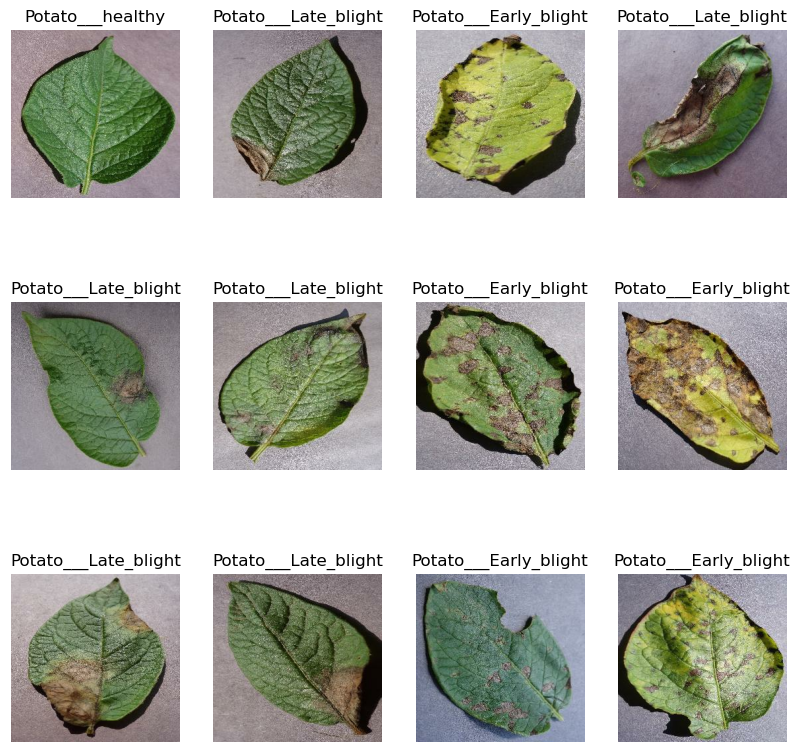

In [7]:
plt.figure(figsize=(10,10))
for batch, label in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(batch[i].numpy().astype('uint8'))
        plt.title(class_name[label[i]])
        plt.axis('off')
    

In [8]:
train = len(dataset) * 0.8
train = int(train)
print(int(train))

54


In [9]:
train_ds = dataset.take(train)
len(train_ds)


54

In [10]:
test_ds = dataset.skip(train)
print(len(test_ds))

14


In [11]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [12]:
def dataset_partition(ds, train_split = 0.8, val_split = 0.1,
    test_split = 0.1, shuffle = True, shuffle_size = 10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(train_split * ds_size)
    
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds =  ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [13]:
train_ds, val_ds, test_ds = dataset_partition(dataset)

cache() tiene la imagen en memoria y mejorea la perfomance

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [15]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [16]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [17]:
CHANNEL = 3
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNEL)
n_classes = 3


model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation='softmax'), 
    
])

In [18]:
# especificando explícitamente el tamaño de entrada que se espera
# si es None indica que el tamaño de lote puede variar model.build(input_shape=(None, 8))
# necesita 4 argumentos 
model.build(input_shape = input_shape)

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

SparseCategoricalCrossentropy se utiliza comúnmente 
para problemas de clasificación donde las etiquetas son enteros  

Cuando from_logits está establecido en False (que es el valor predeterminado), 
se espera que las predicciones del modelo sean las probabilidades de pertenencia 
a cada clase (es decir, después de aplicar una función de activación softmax).
 En este caso, la función de pérdida calculará la pérdida utilizando 
las probabilidades directamente.

En TensorFlow, la función de pérdida SparseCategoricalCrossentropy se utiliza comúnmente para problemas de clasificación donde las etiquetas son enteros (categóricos) en lugar de codificación one-hot. Cuando se trabaja con esta función de pérdida, se tiene la opción de especificar el parámetro from_logits.

Cuando from_logits está establecido en False (que es el valor predeterminado), se espera que las predicciones del modelo sean las probabilidades de pertenencia a cada clase (es decir, después de aplicar una función de activación softmax). En este caso, la función de pérdida calculará la pérdida utilizando las probabilidades directamente.

python

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

Por otro lado, cuando from_logits se establece en True, 
se espera que las predicciones del modelo sean las "logits" 
antes de aplicar la función softmax. Las "logits" son los valores reales generados 
por la última capa del modelo antes de la activación softmax. En este caso, 
la función de pérdida aplicará internamente la función softmax antes de calcular la pérdida.

La elección entre from_logits=False y from_logits=True depende de cómo estén formuladas las salidas de tu modelo. Si la última capa de tu modelo ya aplica la función softmax, debes usar from_logits=False. Si las salidas son "logits" sin la función softmax, entonces debes usar from_logits=True.

In [20]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [21]:
history = model.fit(
    train_ds,
    epochs= EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 2,
    validation_data = val_ds
)

Epoch 1/10
54/54 - 62s - loss: 0.9024 - accuracy: 0.4853 - val_loss: 0.8382 - val_accuracy: 0.6562 - 62s/epoch - 1s/step
Epoch 2/10
54/54 - 64s - loss: 0.7203 - accuracy: 0.6907 - val_loss: 0.5264 - val_accuracy: 0.7812 - 64s/epoch - 1s/step
Epoch 3/10
54/54 - 71s - loss: 0.4991 - accuracy: 0.8110 - val_loss: 0.4479 - val_accuracy: 0.8177 - 71s/epoch - 1s/step
Epoch 4/10
54/54 - 66s - loss: 0.3848 - accuracy: 0.8480 - val_loss: 0.2724 - val_accuracy: 0.9219 - 66s/epoch - 1s/step
Epoch 5/10
54/54 - 67s - loss: 0.2418 - accuracy: 0.9155 - val_loss: 0.2592 - val_accuracy: 0.8854 - 67s/epoch - 1s/step
Epoch 6/10
54/54 - 59s - loss: 0.1893 - accuracy: 0.9290 - val_loss: 0.1873 - val_accuracy: 0.9427 - 59s/epoch - 1s/step
Epoch 7/10
54/54 - 59s - loss: 0.2173 - accuracy: 0.9155 - val_loss: 0.4729 - val_accuracy: 0.7917 - 59s/epoch - 1s/step
Epoch 8/10
54/54 - 59s - loss: 0.1383 - accuracy: 0.9437 - val_loss: 0.1778 - val_accuracy: 0.9427 - 59s/epoch - 1s/step
Epoch 9/10
54/54 - 61s - loss: 0

In [22]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 3s 242ms/step - loss: 0.2984 - accuracy: 0.8984


In [23]:
scores

[0.29837900400161743, 0.8984375]

In [24]:
history

In [25]:
history.params

{'verbose': 2, 'epochs': 10, 'steps': 54}

In [26]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [27]:
history.history['accuracy']

[0.48532864451408386,
 0.690727710723877,
 0.8110328912734985,
 0.8480046987533569,
 0.9154929518699646,
 0.9289906024932861,
 0.9154929518699646,
 0.9436619877815247,
 0.9489436745643616,
 0.9636150002479553]

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and validation accuracy')

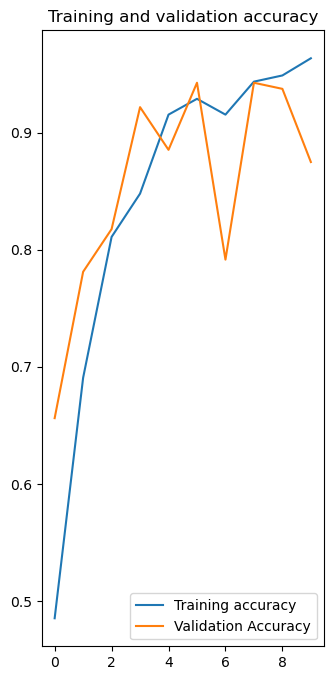

In [29]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and validation accuracy')

Text(0.5, 1.0, 'Training and validation loss')

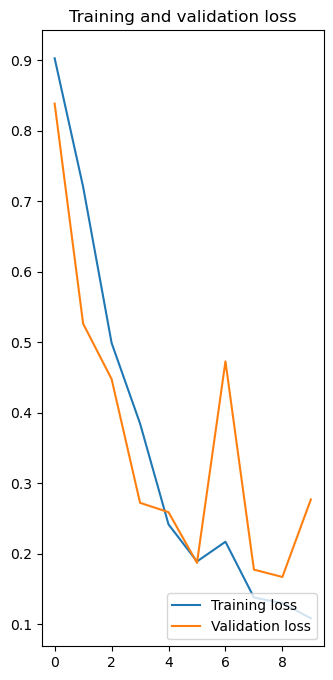

In [30]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), loss, label='Training loss')
plt.plot(range(EPOCHS), val_loss, label='Validation loss')
plt.legend(loc='lower right')
plt.title('Training and validation loss')

first image to predict
first image actual label:  Potato___Early_blight
1/1 [==============================] - 0s 438ms/step
[0.27606198 0.6982196  0.02571839]
Predicted label:  Potato___Late_blight


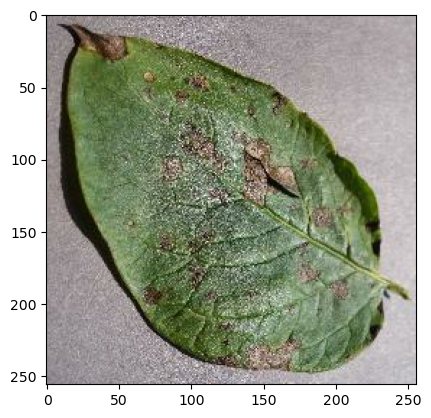

In [31]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print('first image to predict')
    plt.imshow(first_image)
    print('first image actual label: ', class_name[first_label])
    
    batch_prediction = model.predict(images_batch)
    print(batch_prediction[0])
    print('Predicted label: ', class_name[np.argmax(batch_prediction[0])])

In [32]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 28ms/step


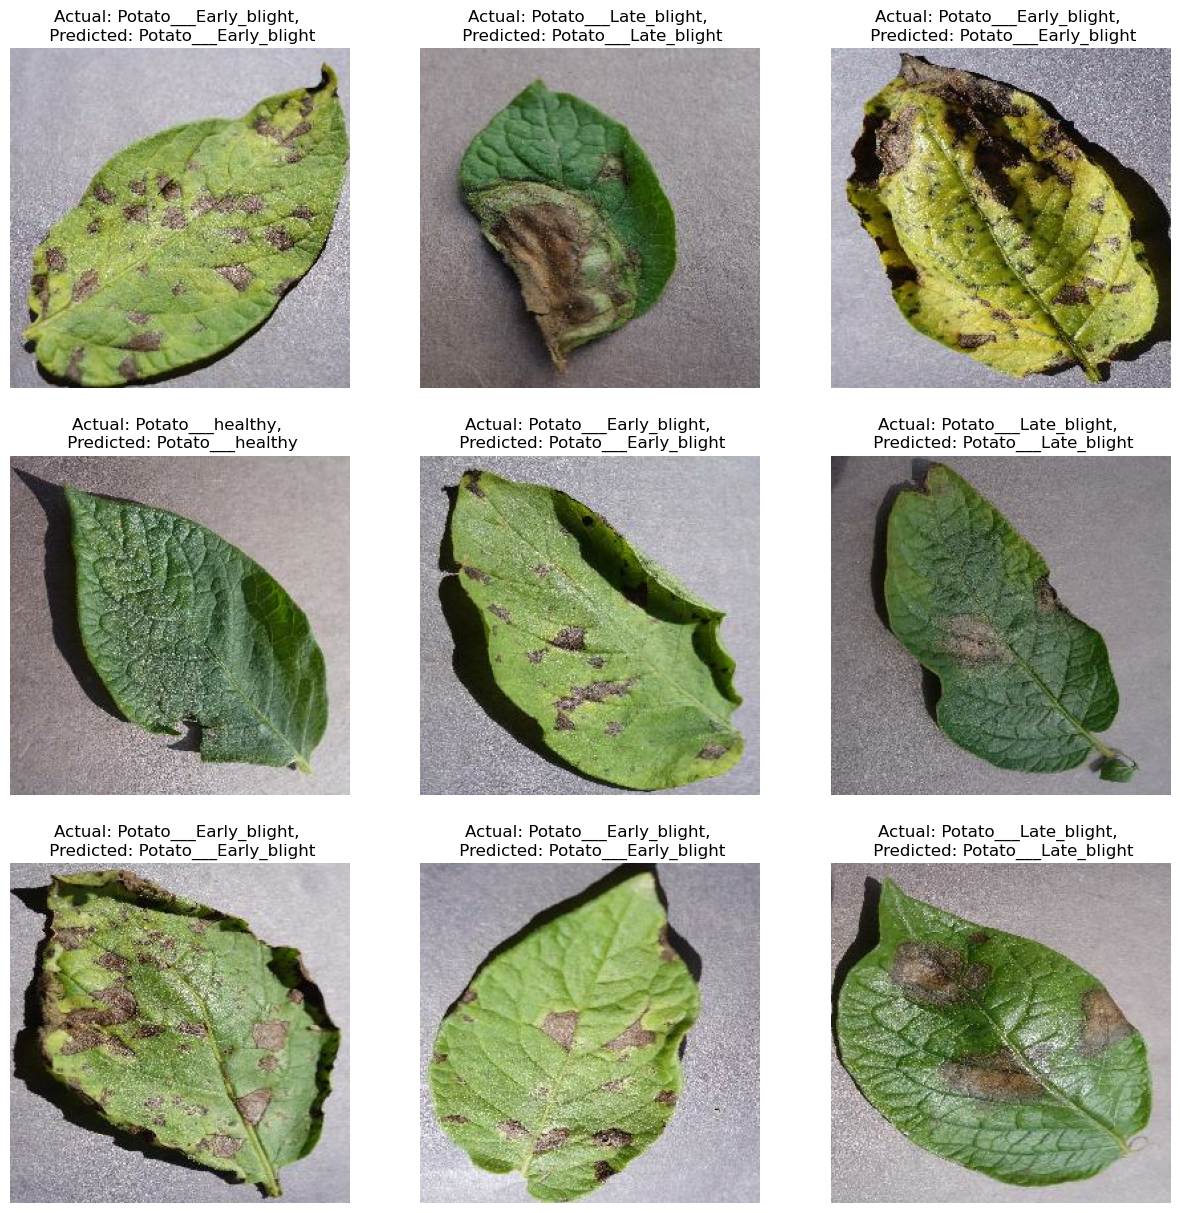

In [33]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
               
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]]
        
        plt.title(f'Actual: {actual_class}, \n Predicted: {predicted_class}')
        
        plt.axis('off')

In [34]:
import os
os.listdir('models')

['2', '3']

In [35]:
#incrementamos en 1 la version 
model_version = max([int(i) for i in os.listdir('models') + [0]]) + 1


In [36]:
#guardamos la version del modelo, si hacemos un cambio guardamos en una nueva version
model.save(f'models/{model_version}')

INFO:tensorflow:Assets written to: models/4\assets


INFO:tensorflow:Assets written to: models/4\assets
